In [55]:
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
from tqdm import tqdm
import sklearn as sk
import os
import random
import math

In [56]:
tf.test.is_built_with_cuda()

True

In [57]:
IMG_SIZE = 224

PATH = "video_data/surveillance_dataset/"

In [58]:
def video_to_frames(p):
    #assert os.path.exists(p)
    cap = cv2.VideoCapture(p)
    
    #assert cap
    rate = math.floor(cap.get(3))

    ImageFrames = []
    #assert cap.isOpened()
    

    '''make sure to figure out how to extract a certain amount of frames so you don't use too much memory'''
    while cap.isOpened():
        #ID = cap.get(1)
        
        success, image = cap.read()
        n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        mid = int(n_frames/2)
        first_q = int(n_frames/4)
        third_q = int(n_frames * .75)
        end = n_frames
        #print(n_frames)
        #assert success

        if success:

            for frame in range(n_frames):
                if frame == first_q or frame == mid or frame == third_q or frame == end:
                    
                    
                    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    ImageFrames.append(image)
                else: continue
            cap.release()
    #print("successful frame capture")
            return ImageFrames

        else: 
            break

In [59]:
CATEGORIES = ["fight", "noFight"]
X_set = []
y_set = []
for category in os.listdir(PATH):
    
    
    path = os.path.join(PATH, category)
    #print(path)
    #assert os.path.exists(path)


    class_num = CATEGORIES.index(category)
    for i, video in tqdm(enumerate(os.listdir(path)), total=len(os.listdir(path))):

        #print(path + '/' + video)
        #print(os.path.join(path, video))
        frames = video_to_frames(path + '/' + video)
        if frames:
        
            for j, frame in enumerate(frames):
                X_set.append(frame)
                y_set.append(class_num)
        else: continue

            
print("success")

100%|██████████| 150/150 [00:02<00:00, 64.84it/s]

success


In [60]:
X_set = np.array(X_set).reshape(-1 , IMG_SIZE * IMG_SIZE * 3)
y_set = np.array(y_set)
len(X_set), len(y_set)

(900, 900)

In [61]:
type(y_set), type(X_set)


(numpy.ndarray, numpy.ndarray)

In [62]:
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split

stratified_sample = StratifiedShuffleSplit(n_splits=2, test_size=0.2)

for train_index, test_index in stratified_sample.split(X_set, y_set):
    X_train, X_test = X_set[train_index], X_set[test_index]
    y_train, y_test = y_set[train_index], y_set[test_index]

In [63]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((720, 150528), (180, 150528), (720,), (180,))

In [64]:
# strat_sample = StratifiedShuffleSplit(n_splits=2, test_size=0.5)

# for train_index, test_index in strat_sample.split(X_test, y_test):
#     X_test_nn, X_val = X_test[train_index], X_test[test_index]
#     y_test_nn, y_val = y_test[train_index], y_test[test_index]

In [65]:
X_train = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, 3) / 255
X_test_nn = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, 3) / 255
# X_val = X_val.reshape(-1, IMG_SIZE, IMG_SIZE, 3) / 255

y_train = np.asarray(y_train)
y_test_nn = np.asarray(y_test)
# y_val = np.asarray(y_val)

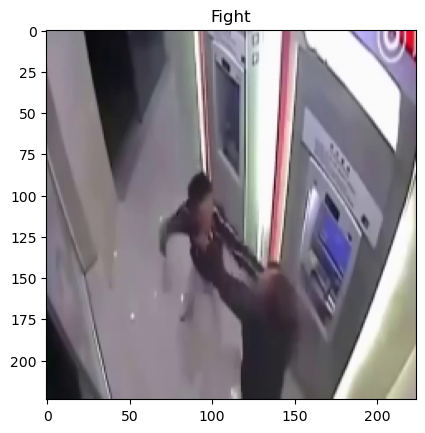

In [66]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_sample(s):
    output =''
    if y_train[s] == 1:
        output = "noFight"
    else: output = "Fight"
    plt.title(output)
    plt.imshow(X_train[s])

show_sample(1)

In [67]:
print(f" X_train shape: {X_train.shape}, X_train data type: {X_train.dtype}")
print(f"y_train shape: {y_train.shape}")

 X_train shape: (720, 224, 224, 3), X_train data type: float64
y_train shape: (720,)


In [68]:
type(X_train), type(X_test_nn)
#  type(X_val)

(numpy.ndarray, numpy.ndarray)

In [69]:
from tensorflow.keras.utils import Sequence


class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

train_gen = DataGenerator(X_train, y_train, 16)
test_gen = DataGenerator(X_test_nn, y_test_nn, 16)
# val_gen = DataGenerator(X_val, y_val, 16)

In [70]:
print(tf.__version__)

2.8.0


In [71]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.applications.efficientnet import preprocess_input

In [72]:
from tensorflow.keras import Sequential, layers

# data_augmentation = Sequential(
#     [
#         layers.RandomFlip("horizontal_and_vertical"),
#         layers.RandomRotation(0.1),
#         layers.RandomZoom(0.1),
#         layers.RandomContrast(factor=0.1),
#         layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
#     ],
#     name="img_augmentation"
# )
data_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation"
)

In [73]:
def build_model(input_shape, data_aug, trainable=True, dropout=0.5):
        inputs = keras.Input(shape=input_shape)
        x = data_aug(inputs)
        x = preprocess_input(x)

        baseModel = EfficientNetV2B0(weights=None, 
                                   pooling='avg',
                                   include_top=False, 
                                   input_tensor=x)
        baseModel.trainable = trainable

        headModel = baseModel.output
        #headModel = layers.GlobalAveragePooling2D()(headModel)
        headModel = layers.Dropout(dropout)(headModel)
        outputs = layers.Dense(1, activation="sigmoid")(headModel)
        model = Model(inputs, outputs)

        return model

In [74]:
EffNet = build_model(input_shape=(224,224) + (3,),
                     data_aug= data_augmentation,
                     trainable=True,
                     dropout=0.3)

In [75]:
from keras.callbacks import EarlyStopping
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, mode='min', min_delta=0.0001)
    
]

#keep batchlayers intact, reduces learning time
# for layer in EffNet.layers:
#     if isinstance(layer, layers.BatchNormalization):
#         layer.trainable = False
#     else:
#         layer.trainable = True

In [94]:
mets = ['binary_accuracy', 'acc']
EffNet.compile(loss=tf.keras.losses.BinaryCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
               metrics=mets)

            

In [77]:
gpus = tf.config.list_physical_devices('GPU')

print(gpus)

print("Num Physical Devices Available: ", len(gpus))

print(tf.__version__)
print(cv2.__version__)

if gpus:
      # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num Physical Devices Available:  1
2.8.0
4.6.0
1 Physical GPUs, 1 Logical GPU


In [93]:
len(train_gen) *16, len(train_gen)

(720, 45)

In [95]:
history = EffNet.fit(train_gen,
                     batch_size=16,
                     epochs=50, 
                     steps_per_epoch= len(train_gen),
                    #  callbacks= callbacks,
                     #validation_data=val_gen,                    
                     verbose=1)

print("Training Complete.")

Epoch 1/25
45/45 [==============================] - 16s 158ms/step - loss: 0.5108 - binary_accuracy: 0.7333 - acc: 0.7333
Epoch 2/25
45/45 [==============================] - 7s 158ms/step - loss: 0.4784 - binary_accuracy: 0.7681 - acc: 0.7681
Epoch 3/25
45/45 [==============================] - 7s 158ms/step - loss: 0.4743 - binary_accuracy: 0.7833 - acc: 0.7833
Epoch 4/25
45/45 [==============================] - 7s 159ms/step - loss: 0.4688 - binary_accuracy: 0.7653 - acc: 0.7653
Epoch 5/25
45/45 [==============================] - 7s 159ms/step - loss: 0.4698 - binary_accuracy: 0.7639 - acc: 0.7639
Epoch 6/25
45/45 [==============================] - 7s 159ms/step - loss: 0.4743 - binary_accuracy: 0.7639 - acc: 0.7639
Epoch 7/25
45/45 [==============================] - 7s 159ms/step - loss: 0.4793 - binary_accuracy: 0.7667 - acc: 0.7667
Epoch 8/25
45/45 [==============================] - 7s 158ms/step - loss: 0.4803 - binary_accuracy: 0.7528 - acc: 0.7528
Epoch 9/25
45/45 [=============

In [96]:
def eval_model(model):
    acc = model.evaluate(test_gen)
    print("This model's accuracy is:", round(acc[1], 4)*100 , "%")


eval_model(EffNet)

12/12 [==============================] - 2s 41ms/step - loss: 0.6774 - binary_accuracy: 0.6389 - acc: 0.6389
This model's accuracy is: 63.89 %


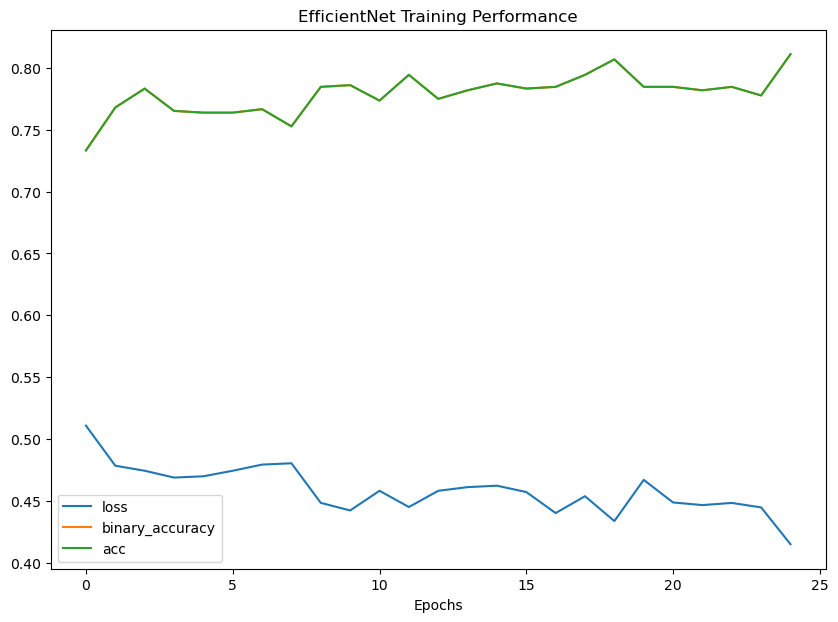

In [98]:
def view_performance(model_hist):
    graph = pd.DataFrame(model_hist.history).plot(figsize=(10,7), title="EfficientNet Training Performance", xlabel="Epochs")



view_performance(history)

KeyError: 'val_accuracy'

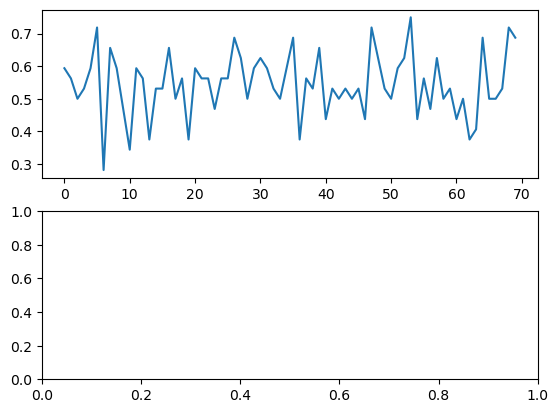

In [81]:
def plot_history(h):
    fig, axs = plt.subplots(2)

    axs[0].plot(h.history['acc'], label = "train accuracy")
    axs[0].plot(h.history['val_accuracy'], label = "test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    axs[1].plot(h.history['loss'], label = "train error")
    axs[1].plot(h.history['val_loss'], label = "test error")
    axs[1].set_ylabel("Accuracy")
    axs[1].legend(loc="lower right")
    axs[1].set_title("Accuracy eval")

plot_history(history)

In [103]:
EffNet.save("EffNet_1")

INFO:tensorflow:Assets written to: EffNet_1\assets
